In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
%matplotlib inline

In [2]:
from nmt_run import *

fisher + callhome sp/es - en configuration
--------------------------------------------------
loading info_dict from=./callhome_fbank_out/info.dict


 35%|███▌      | 48638/138708 [00:00<00:00, 486368.87it/s]

--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp
creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 14284/14284 [00:00<00:00, 597221.19it/s]


creating buckets for: callhome_devtest
creating buckets for key: sp
creating buckets for: callhome_evltest
creating buckets for key: sp
creating buckets for: callhome_train
creating buckets for key: sp
--------------------------------------------------
saving info dict in: ./callhome_fbank_out/buckets_sp.dict
all done ...
--------------------------------------------------
showing buckets for category: fisher_dev
number of buckets=8, width of each bucket=256
index | width | num   
    0 |     0 |   1804
    1 |   256 |   1047
    2 |   512 |    559
    3 |   768 |    348
    4 |  1024 |    158
    5 |  1280 |     53
    6 |  1536 |      6
    7 |  1792 |      2
--------------------------------------------------
showing buckets for category: fisher_dev2
number of buckets=8, width of each bucket=256
index | width | num   
    0 |     0 |   1656
    1 |   256 |   1177
    2 |   512 |    546
    3 |   768 |    363
    4 |  1024 |    150
    5 |  1280 |     50
    6 |  1536 |     16
    7 | 

/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer2/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer


In [3]:
model_files = [f for f in os.listdir(os.path.dirname(model_fil))
                   if os.path.basename(model_fil).replace('.model','') in f]
# print(model_files)

In [4]:
max_model_fil = max(model_files, key=lambda s: int(s.split('_')[-1].split('.')[0]))

In [5]:
max_model_fil

'seq2seq_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4_129.model'

In [6]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
fsh_fbank/seq2seq_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4_129.model
loading ...
finished loading ..


In [7]:
log_dev_fil_name

'fsh_fbank/dev_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4.log'

In [8]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.loadtxt(log_dev_fil_name, delimiter=',', skiprows=0).transpose()

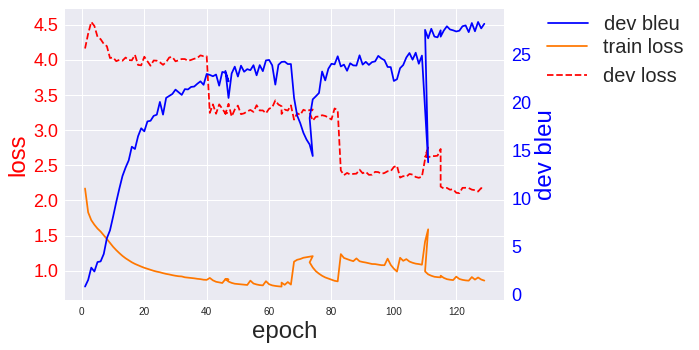

In [9]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax1.set_xlim(0, 60)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [10]:
import nltk.translate.bleu_score

In [18]:
def play_utt(utt, m_dict):
    sr, y = scipy.io.wavfile.read(os.path.join(wavs_path, utt.rsplit("-",1)[0]+'.wav'))
    start_t = min(seg['start'] for seg in m_dict[utt]['seg'])
    end_t = max(seg['end'] for seg in m_dict[utt]['seg'])
    print(start_t, end_t)
    start_t_samples, end_t_samples = int(start_t*sr), int(end_t*sr)
    display(Audio(y[start_t_samples:end_t_samples], rate=sr))

In [19]:
def display_words(m_dict, v_dict, preds, utts, dec_key, min_len=0, max_len=MAX_EN_LEN):
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        if len(en.split(" ")) >= min_len and len(en.split(" ")) <= max_len:
            # for reference, 1st word is GO_ID, no need to display
            print("Utterance: {0:s}".format(u))
            display_pp = PrettyTable(["cat","sent"], hrules=True)
            display_pp.align = "l"
            display_pp.header = False
            display_pp.add_row(["es ref", textwrap.fill(es,50)])
            display_pp.add_row(["en ref", textwrap.fill(en,50)])
            display_pp.add_row(["en pred", textwrap.fill(p,50)])

            print(display_pp)
            play_utt(u, m_dict)

In [46]:
def display_words_latex(m_dict, v_dict, preds, utts, dec_key, min_len=0, max_len=2*MAX_EN_LEN):
    print("min length={0:d}, max length={1:d}".format(min_len, max_len))
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    total_matching_len = 0

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        if len(es.split(" ")) >= min_len and len(es.split(" ")) <= max_len:
            total_matching_len += 1
            # for reference, 1st word is GO_ID, no need to display
            print("Utterance: {0:s}".format(u))
            print("{0:d} & {1:s} & {2:s} & {3:s} \\\\".format(total_matching_len, es, en, p))

    print("total utts matching length filters={0:d}".format(total_matching_len))

### Fisher dev

In [22]:
key='fisher_dev'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 100

In [23]:
cat_speech_path = os.path.join(out_path, key)
wavs_path = os.path.join(out_path, "wavs")

In [15]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
fsh_pred_sents, fsh_utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|                                                  | 0/3977 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 130


b=2,l=2.32,avg=2.15: 100%|██████████████████| 3977/3977 [02:20<00:00,  8.54it/s]

********** dev mean loss=2.1470
-
--------------------------------------------------------------------------------


In [103]:
min_len, max_len= 0,1

In [104]:
display_words(m_dict, v_dict, fsh_pred_sents, fsh_utts, dec_key, min_len=min_len, max_len=max_len)

Utterance: 20051023_232057_325_fsp-B-81
+---------+-------+
| es ref  | hm mm |
+---------+-------+
| en ref  | hmm   |
+---------+-------+
| en pred | mhm   |
+---------+-------+
514.68 517.5


Utterance: 20051026_180724_341_fsp-A-68
+---------+------+
| es ref  | yea  |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | yeah |
+---------+------+
418.39 422.92


Utterance: 20051025_212334_337_fsp-A-90
+---------+---------+
| es ref  | oh      |
+---------+---------+
| en ref  | oh      |
+---------+---------+
| en pred | yes yes |
+---------+---------+
645.7 648.9


Utterance: 20051010_212418_225_fsp-B-24
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | ha  |
+---------+-----+
| en pred | aha |
+---------+-----+
182.09 182.7


Utterance: 20051010_212418_225_fsp-B-21
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
144.28 145.7


Utterance: 20051019_190221_288_fsp-B-14
+---------+-----+
| es ref  | eh  |
+---------+-----+
| en ref  | eh  |
+---------+-----+
| en pred | yes |
+---------+-----+
50.4 52.32


Utterance: 20051017_234550_276_fsp-B-132
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
698.92 699.78


Utterance: 20051023_232057_325_fsp-B-18
+---------+-------+
| es ref  | hm mm |
+---------+-------+
| en ref  | hmm   |
+---------+-------+
| en pred | mm    |
+---------+-------+
90.91 92.06


Utterance: 20051017_180712_270_fsp-B-38
+---------+-------+
| es ref  | hm mm |
+---------+-------+
| en ref  | hmm   |
+---------+-------+
| en pred | mm    |
+---------+-------+
252.91 254.12


Utterance: 20051026_211309_346_fsp-B-71
+---------+-----+
| es ref  | mm  |
+---------+-----+
| en ref  | mmm |
+---------+-----+
| en pred | mm  |
+---------+-----+
532.67 533.38


Utterance: 20051019_190221_288_fsp-B-41
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
194.91 195.77


Utterance: 20051016_180547_265_fsp-A-41
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ah |
+---------+----+
379.85 381.61


Utterance: 20051009_210519_219_fsp-B-15
+---------+-------------+
| es ref  | exactamente |
+---------+-------------+
| en ref  | exactly     |
+---------+-------------+
| en pred | exactly     |
+---------+-------------+
138.57 140.74


Utterance: 20051017_234550_276_fsp-B-56
+---------+-------+
| es ref  | ajá   |
+---------+-------+
| en ref  | right |
+---------+-------+
| en pred | aha   |
+---------+-------+
264.97 265.93


Utterance: 20051017_234550_276_fsp-B-88
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | ajá |
+---------+-----+
| en pred | aha |
+---------+-----+
429.05 429.65


Utterance: 20051024_181110_329_fsp-A-82
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | hm  |
+---------+-----+
| en pred | mhm |
+---------+-----+
583.22 584.38


Utterance: 20051019_210146_289_fsp-B-64
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
402.64 403.46


Utterance: 20051024_180453_327_fsp-A-67
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
546.72 549.04


Utterance: 20051009_182032_217_fsp-A-121
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
548.95 549.71


Utterance: 20051025_212334_337_fsp-B-13
+---------+-----------------+
| es ref  | ajá             |
+---------+-----------------+
| en ref  | aha             |
+---------+-----------------+
| en pred | hmm that s more |
+---------+-----------------+
116.7 118.04


Utterance: 20051017_220530_275_fsp-A-43
+---------+-------+
| es ref  | ajá   |
+---------+-------+
| en ref  | right |
+---------+-------+
| en pred | aha   |
+---------+-------+
266.69 267.4


Utterance: 20051009_182032_217_fsp-B-26
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
92.6 93.51


Utterance: 20051022_180817_311_fsp-B-93
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
701.09 702.05


Utterance: 20051017_234550_276_fsp-B-91
+---------+-----+
| es ref  | ohh |
+---------+-----+
| en ref  | ohh |
+---------+-----+
| en pred | oh  |
+---------+-----+
443.05 444.57


Utterance: 20051025_212334_337_fsp-A-55
+---------+--------------+
| es ref  | ya sí sí     |
+---------+--------------+
| en ref  | yes          |
+---------+--------------+
| en pred | yeah yes yes |
+---------+--------------+
416.95 418.86


Utterance: 20051018_210744_280_fsp-A-80
+---------+------+
| es ref  | yeah |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | yeah |
+---------+------+
583.67 585.29


Utterance: 20051024_181110_329_fsp-A-38
+---------+---------+
| es ref  | mhm mhm |
+---------+---------+
| en ref  | mhm     |
+---------+---------+
| en pred | mhm mhm |
+---------+---------+
220.34 221.75


Utterance: 20051017_234550_276_fsp-B-14
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
43.02 43.82


Utterance: 20051009_182032_217_fsp-A-129
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
589.84 590.7


Utterance: 20051017_234550_276_fsp-A-76
+---------+-------------+
| es ref  | ¿ en serio  |
+---------+-------------+
| en ref  | seriously   |
+---------+-------------+
| en pred | that s cool |
+---------+-------------+
382.29 383.76


Utterance: 20051023_232057_325_fsp-A-33
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
195.45 196.31


Utterance: 20051018_210744_280_fsp-A-92
+---------+-----+
| es ref  | si  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
648.68 649.59


Utterance: 20051024_181110_329_fsp-A-51
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
314.71 315.27


Utterance: 20051009_210519_219_fsp-A-3
+---------+----+
| es ref  | hm |
+---------+----+
| en ref  | hm |
+---------+----+
| en pred | mm |
+---------+----+
7.77 8.58


Utterance: 20051026_211309_346_fsp-B-32
+---------+----------+
| es ref  | entonces |
+---------+----------+
| en ref  | then     |
+---------+----------+
| en pred | then     |
+---------+----------+
225.49 226.76


Utterance: 20051018_210744_280_fsp-A-79
+---------+------+
| es ref  | ajá  |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | aha  |
+---------+------+
575.79 576.8


Utterance: 20051009_182032_217_fsp-A-118
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mmh |
+---------+-----+
| en pred | mhm |
+---------+-----+
526.66 527.72


Utterance: 20051019_190221_288_fsp-A-24
+---------+------+
| es ref  | ajá  |
+---------+------+
| en ref  | ahhh |
+---------+------+
| en pred | aha  |
+---------+------+
90.78 91.44


Utterance: 20051019_190221_288_fsp-A-1
+---------+-------+
| es ref  | ¿hola |
+---------+-------+
| en ref  | hello |
+---------+-------+
| en pred | hello |
+---------+-------+
0.0 1.06


Utterance: 20051017_220530_275_fsp-A-73
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
452.65 453.46


Utterance: 20051019_190221_288_fsp-B-7
+---------+-----+
| es ref  | eh  |
+---------+-----+
| en ref  | eh  |
+---------+-----+
| en pred | yes |
+---------+-----+
20.42 21.48


Utterance: 20051024_180453_327_fsp-A-31
+---------+------+
| es ref  | ajá  |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | aha  |
+---------+------+
200.45 201.82


Utterance: 20051022_180817_311_fsp-A-10
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
37.5 38.3


Utterance: 20051019_190221_288_fsp-A-65
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mmh |
+---------+-----+
| en pred | mm  |
+---------+-----+
331.64 332.6


Utterance: 20051016_180547_265_fsp-B-73
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
612.95 613.59


Utterance: 20051024_181110_329_fsp-A-53
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
341.85 342.51


Utterance: 20051026_211309_346_fsp-B-88
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
676.73 677.64


Utterance: 20051019_210146_289_fsp-B-97
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mhm |
+---------+-----+
612.64 613.74


Utterance: 20051009_210519_219_fsp-B-1
+---------+-------+
| es ref  | ¿alo  |
+---------+-------+
| en ref  | hi    |
+---------+-------+
| en pred | hello |
+---------+-------+
0.2 1.36


Utterance: 20051018_210744_280_fsp-A-47
+---------+-----+
| es ref  | si  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
312.64 313.65


Utterance: 20051025_212334_337_fsp-B-99
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mmm |
+---------+-----+
| en pred | mm  |
+---------+-----+
704.51 705.49


Utterance: 20051017_234550_276_fsp-A-54
+---------+------+
| es ref  | cier |
+---------+------+
| en ref  | true |
+---------+------+
| en pred | true |
+---------+------+
257.99 258.4


Utterance: 20051022_180817_311_fsp-B-92
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
692.62 693.43


Utterance: 20051018_210220_279_fsp-B-15
+---------+------+
| es ref  | ja   |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | aha  |
+---------+------+
140.86 141.74


Utterance: 20051018_210220_279_fsp-A-50
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
492.04 493.44


Utterance: 20051022_180817_311_fsp-A-87
+---------+-------+
| es ref  | ajá   |
+---------+-------+
| en ref  | ahhhh |
+---------+-------+
| en pred | aha   |
+---------+-------+
712.12 712.61


Utterance: 20051019_230329_292_fsp-A-63
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ah |
+---------+----+
544.39 546.48


Utterance: 20051024_180453_327_fsp-A-8
+---------+------+
| es ref  | bien |
+---------+------+
| en ref  | good |
+---------+------+
| en pred | aha  |
+---------+------+
30.0 31.31


Utterance: 20051024_180453_327_fsp-A-21
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
119.95 121.21


Utterance: 20051017_220530_275_fsp-A-96
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
652.72 653.48


Utterance: 20051017_220530_275_fsp-A-51
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | om  |
+---------+-----+
| en pred | mm  |
+---------+-----+
317.64 318.55


Utterance: 20051026_180724_341_fsp-A-11
+---------+-------+
| es ref  | hm mm |
+---------+-------+
| en ref  | hmm   |
+---------+-------+
| en pred | mm    |
+---------+-------+
97.7 98.66


Utterance: 20051023_232057_325_fsp-B-92
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | ok  |
+---------+-----+
| en pred | aha |
+---------+-----+
592.65 594.01


Utterance: 20051024_181110_329_fsp-A-87
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mhm |
+---------+-----+
620.02 620.78


Utterance: 20051026_211309_346_fsp-A-21
+---------+-----------+
| es ref  | right     |
+---------+-----------+
| en ref  | right     |
+---------+-----------+
| en pred | sure cool |
+---------+-----------+
180.76 182.02


Utterance: 20051019_190221_288_fsp-B-5
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
12.43 14.0


Utterance: 20051009_182032_217_fsp-A-53
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ok |
+---------+----+
| en pred | ah |
+---------+----+
216.9 217.66


Utterance: 20051023_232057_325_fsp-B-61
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
363.47 364.83


Utterance: 20051017_220530_275_fsp-B-18
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
92.5 93.46


Utterance: 20051022_180817_311_fsp-B-39
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
282.75 283.98


Utterance: 20051016_180547_265_fsp-B-77
+---------+------+
| es ref  | ajá  |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | mhm  |
+---------+------+
636.89 638.1


Utterance: 20051017_234550_276_fsp-B-89
+---------+-----+
| es ref  | ohh |
+---------+-----+
| en ref  | ohh |
+---------+-----+
| en pred | oh  |
+---------+-----+
431.88 433.19


Utterance: 20051019_230329_292_fsp-A-79
+---------+------+
| es ref  | ajá  |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | aha  |
+---------+------+
655.23 656.62


Utterance: 20051017_234550_276_fsp-B-100
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
504.16 504.77


Utterance: 20051019_190221_288_fsp-A-38
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | aha |
+---------+-----+
179.39 180.2


Utterance: 20051017_180712_270_fsp-A-4
+---------+------+
| es ref  | okay |
+---------+------+
| en ref  | okay |
+---------+------+
| en pred | okay |
+---------+------+
16.59 17.55


Utterance: 20051026_180724_341_fsp-B-18
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
131.28 132.94


Utterance: 20051017_220530_275_fsp-B-90
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ah |
+---------+----+
646.66 647.57


Utterance: 20051018_210220_279_fsp-B-55
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
536.33 537.5


Utterance: 20051017_220530_275_fsp-B-95
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
673.45 674.05


Utterance: 20051024_181110_329_fsp-A-9
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | ah  |
+---------+-----+
| en pred | aha |
+---------+-----+
29.62 30.38


Utterance: 20051019_190221_288_fsp-A-19
+---------+------+
| es ref  | mhm  |
+---------+------+
| en ref  | mmmm |
+---------+------+
| en pred | aha  |
+---------+------+
65.26 67.08


Utterance: 20051017_180712_270_fsp-A-69
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
545.19 546.1


Utterance: 20051018_210744_280_fsp-A-78
+---------+-----+
| es ref  | si  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
571.34 572.5


Utterance: 20051017_220530_275_fsp-B-76
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
491.37 492.43


Utterance: 20051017_234550_276_fsp-B-64
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
314.86 315.52


Utterance: 20051023_232057_325_fsp-A-42
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
254.24 254.65


Utterance: 20051016_180547_265_fsp-A-40
+---------+------------+
| es ref  | no         |
+---------+------------+
| en ref  | no         |
+---------+------------+
| en pred | no they re |
+---------+------------+
375.53 376.78


Utterance: 20051024_181110_329_fsp-A-96
+---------+--------------+
| es ref  | realmente    |
+---------+--------------+
| en ref  | actually     |
+---------+--------------+
| en pred | mm seeing it |
+---------+--------------+
677.54 679.26


Utterance: 20051018_210744_280_fsp-B-5
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ah |
+---------+----+
18.6 19.61


Utterance: 20051019_210146_289_fsp-B-87
+---------+------+
| es ref  | mhm  |
+---------+------+
| en ref  | mhnb |
+---------+------+
| en pred | mhm  |
+---------+------+
555.58 556.61


Utterance: 20051017_180712_270_fsp-B-35
+---------+------+
| es ref  | ya   |
+---------+------+
| en ref  | ya   |
+---------+------+
| en pred | yeah |
+---------+------+
226.13 227.39


Utterance: 20051016_210626_267_fsp-A-34
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mmh |
+---------+-----+
| en pred | mm  |
+---------+-----+
244.75 245.41


Utterance: 20051010_212418_225_fsp-A-7
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
31.84 33.14


Utterance: 20051019_190221_288_fsp-A-53
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
250.36 251.47


Utterance: 20051017_220530_275_fsp-B-87
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | no  |
+---------+-----+
603.99 604.6


Utterance: 20051026_211309_346_fsp-A-20
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | ah  |
+---------+-----+
160.99 161.7


Utterance: 20051018_210744_280_fsp-A-95
+---------+-----+
| es ref  | si  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
677.99 678.75


Utterance: 20051018_210744_280_fsp-B-18
+---------+----+
| es ref  | no |
+---------+----+
| en ref  | no |
+---------+----+
| en pred | no |
+---------+----+
98.47 99.43


Utterance: 20051009_182032_217_fsp-B-1
+---------+-----------+
| es ref  | tardes    |
+---------+-----------+
| en ref  | afternoon |
+---------+-----------+
| en pred | late      |
+---------+-----------+
0.05 0.86


Utterance: 20051019_230329_292_fsp-A-59
+---------+-----+
| es ref  | wow |
+---------+-----+
| en ref  | wow |
+---------+-----+
| en pred | wow |
+---------+-----+
514.45 515.84


Utterance: 20051016_180547_265_fsp-B-44
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mmh |
+---------+-----+
| en pred | mm  |
+---------+-----+
390.48 391.56


Utterance: 20051026_211309_346_fsp-A-36
+---------+-------+
| es ref  | okay  |
+---------+-------+
| en ref  | okay  |
+---------+-------+
| en pred | oh ok |
+---------+-------+
308.95 309.81


Utterance: 20051023_232057_325_fsp-B-58
+---------+-------+
| es ref  | claro |
+---------+-------+
| en ref  | sure  |
+---------+-------+
| en pred | ah    |
+---------+-------+
341.88 342.84


Utterance: 20051022_180817_311_fsp-A-53
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
437.22 438.01


Utterance: 20051026_180724_341_fsp-A-41
+---------+-------+
| es ref  | hm mm |
+---------+-------+
| en ref  | hmm   |
+---------+-------+
| en pred | yes   |
+---------+-------+
274.63 277.0


Utterance: 20051017_220530_275_fsp-A-62
+---------+-------+
| es ref  | mhm   |
+---------+-------+
| en ref  | mhm   |
+---------+-------+
| en pred | mm mm |
+---------+-------+
381.84 383.86


Utterance: 20051024_181110_329_fsp-A-73
+---------+-----+
| es ref  | wow |
+---------+-----+
| en ref  | wow |
+---------+-----+
| en pred | wow |
+---------+-----+
504.26 505.68


Utterance: 20051017_234550_276_fsp-B-43
+---------+---------+
| es ref  | crespo  |
+---------+---------+
| en ref  | crespo  |
+---------+---------+
| en pred | grow up |
+---------+---------+
186.22 187.13


Utterance: 20051024_180453_327_fsp-A-82
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
709.8 711.72


Utterance: 20051017_220530_275_fsp-A-74
+---------+------------+
| es ref  | colombiana |
+---------+------------+
| en ref  | colombian  |
+---------+------------+
| en pred | colombia   |
+---------+------------+
454.93 455.89


Utterance: 20051018_210744_280_fsp-B-3
+---------+-------+
| es ref  | annie |
+---------+-------+
| en ref  | annie |
+---------+-------+
| en pred | annie |
+---------+-------+
9.2 9.81


Utterance: 20051010_212418_225_fsp-A-70
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
630.63 631.53


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


568.66 569.57


Utterance: 20051026_180724_341_fsp-B-93
+---------+---------------+
| es ref  | puertorricans |
+---------+---------------+
| en ref  | puertorican   |
+---------+---------------+
| en pred | or who        |
+---------+---------------+
603.88 605.08


Utterance: 20051017_220530_275_fsp-B-60
+---------+------+
| es ref  | yeah |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | aha  |
+---------+------+
391.14 392.4


Utterance: 20051024_180453_327_fsp-B-17
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
89.85 91.46


Utterance: 20051009_182032_217_fsp-B-63
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
255.32 256.07


Utterance: 20051024_180453_327_fsp-B-70
+---------+-------+
| es ref  | eh e- |
+---------+-------+
| en ref  | um    |
+---------+-------+
| en pred | yes   |
+---------+-------+
512.47 514.07


Utterance: 20051019_230329_292_fsp-A-69
+---------+------+
| es ref  | ajá  |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | aha  |
+---------+------+
571.29 572.57


Utterance: 20051009_182032_217_fsp-B-90
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ah |
+---------+----+
388.81 390.33


Utterance: 20051017_234550_276_fsp-A-109
+---------+-------+
| es ref  | claro |
+---------+-------+
| en ref  | sure  |
+---------+-------+
| en pred | sure  |
+---------+-------+
589.13 590.09


Utterance: 20051019_230329_292_fsp-A-32
+---------+----+
| es ref  | oh |
+---------+----+
| en ref  | oh |
+---------+----+
| en pred | oh |
+---------+----+
314.36 316.23


Utterance: 20051024_181110_329_fsp-B-27
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
144.97 145.78


Utterance: 20051022_180817_311_fsp-A-14
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ah |
+---------+----+
70.95 71.71


Utterance: 20051016_180547_265_fsp-B-18
+---------+----+
| es ref  | m  |
+---------+----+
| en ref  | m  |
+---------+----+
| en pred | mm |
+---------+----+
133.09 133.97


Utterance: 20051009_182032_217_fsp-B-31
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
113.73 114.49


Utterance: 20051009_182032_217_fsp-A-117
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
523.93 525.09


Utterance: 20051009_210519_219_fsp-A-32
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
274.26 275.32


Utterance: 20051017_220530_275_fsp-A-46
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | um  |
+---------+-----+
| en pred | mm  |
+---------+-----+
276.65 277.46


Utterance: 20051022_180817_311_fsp-A-75
+---------+---------+
| es ref  | pero    |
+---------+---------+
| en ref  | but     |
+---------+---------+
| en pred | i think |
+---------+---------+
650.38 651.57


Utterance: 20051018_210744_280_fsp-B-28
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | hmm |
+---------+-----+
| en pred | mm  |
+---------+-----+
174.14 174.89


Utterance: 20051024_181110_329_fsp-B-25
+---------+-----+
| es ref  | ¿sí |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
128.8 129.5


Utterance: 20051026_180724_341_fsp-B-70
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
456.29 457.35


Utterance: 20051009_182032_217_fsp-A-87
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
381.99 382.8


Utterance: 20051018_210220_279_fsp-B-34
+---------+-----+
| es ref  | boy |
+---------+-----+
| en ref  | boy |
+---------+-----+
| en pred | uh  |
+---------+-----+
314.91 316.38


Utterance: 20051025_212334_337_fsp-A-13
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
129.86 131.2


Utterance: 20051018_210220_279_fsp-B-65
+---------+-----+
| es ref  | mja |
+---------+-----+
| en ref  | mh  |
+---------+-----+
| en pred | mm  |
+---------+-----+
618.51 619.76


Utterance: 20051026_180724_341_fsp-A-25
+---------+------+
| es ref  | ajá  |
+---------+------+
| en ref  | yes  |
+---------+------+
| en pred | sure |
+---------+------+
174.97 176.88


Utterance: 20051018_210744_280_fsp-A-64
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | um  |
+---------+-----+
| en pred | mm  |
+---------+-----+
453.82 454.47


Utterance: 20051009_182032_217_fsp-B-103
+---------+-------+
| es ref  | ajá   |
+---------+-------+
| en ref  | right |
+---------+-------+
| en pred | aha   |
+---------+-------+
444.16 445.22


Utterance: 20051017_234550_276_fsp-A-92
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | aha |
+---------+-----+
467.87 468.88


Utterance: 20051017_234550_276_fsp-B-7
+---------+-------+
| es ref  | ¿ aha |
+---------+-------+
| en ref  | aha   |
+---------+-------+
| en pred | ah    |
+---------+-------+
23.86 24.41


Utterance: 20051016_180547_265_fsp-B-78
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
641.08 642.03


Utterance: 20051017_180712_270_fsp-A-66
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
516.55 520.08


Utterance: 20051017_180712_270_fsp-B-87
+---------+----+
| es ref  | no |
+---------+----+
| en ref  | no |
+---------+----+
| en pred | no |
+---------+----+
603.63 606.45


Utterance: 20051017_180712_270_fsp-B-32
+---------+------+
| es ref  | okay |
+---------+------+
| en ref  | okay |
+---------+------+
| en pred | okay |
+---------+------+
207.68 210.76


Utterance: 20051019_190221_288_fsp-B-84
+---------+-----+
| es ref  | mm  |
+---------+-----+
| en ref  | mm  |
+---------+-----+
| en pred | yes |
+---------+-----+
579.17 582.06


Utterance: 20051010_212418_225_fsp-B-60
+---------+---------+
| es ref  | ajá     |
+---------+---------+
| en ref  | ok      |
+---------+---------+
| en pred | aha aha |
+---------+---------+
538.59 541.48


Utterance: 20051017_180712_270_fsp-A-25
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
155.39 158.42


Utterance: 20051017_220530_275_fsp-B-83
+---------+----------+
| es ref  | sí       |
+---------+----------+
| en ref  | yes      |
+---------+----------+
| en pred | well yes |
+---------+----------+
569.32 570.68


Utterance: 20051009_182032_217_fsp-B-116
+---------+-----+
| es ref  | ¿ah |
+---------+-----+
| en ref  | ah  |
+---------+-----+
| en pred | ah  |
+---------+-----+
510.63 511.44


Utterance: 20051018_210744_280_fsp-B-20
+---------+-----+
| es ref  | si  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
111.36 111.96


Utterance: 20051017_234550_276_fsp-B-127
+---------+------+
| es ref  | ajá  |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | aha  |
+---------+------+
671.37 672.38


Utterance: 20051019_210146_289_fsp-A-85
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
554.69 555.92


Utterance: 20051017_220530_275_fsp-B-84
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
577.61 578.82


Utterance: 20051016_210626_267_fsp-A-82
+---------+----+
| es ref  | mh |
+---------+----+
| en ref  | mm |
+---------+----+
| en pred | mm |
+---------+----+
679.41 680.42


Utterance: 20051019_230329_292_fsp-A-49
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
429.32 430.34


Utterance: 20051017_234550_276_fsp-A-75
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
374.61 375.52


Utterance: 20051017_180712_270_fsp-B-1
+---------+-------+
| es ref  | hello |
+---------+-------+
| en ref  | hello |
+---------+-------+
| en pred | hello |
+---------+-------+
0.0 0.76


Utterance: 20051016_210626_267_fsp-B-53
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
579.73 580.34


Utterance: 20051009_182032_217_fsp-A-124
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
559.87 560.88


Utterance: 20051017_180712_270_fsp-A-3
+---------+-------+
| es ref  | hola  |
+---------+-------+
| en ref  | hello |
+---------+-------+
| en pred | hello |
+---------+-------+
8.92 9.83


Utterance: 20051019_210146_289_fsp-B-27
+---------+------+
| es ref  | ya   |
+---------+------+
| en ref  | ya   |
+---------+------+
| en pred | yeah |
+---------+------+
171.73 172.89


Utterance: 20051009_182032_217_fsp-A-79
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
339.07 340.03


Utterance: 20051023_232057_325_fsp-B-35
+---------+-----+
| es ref  | y   |
+---------+-----+
| en ref  | and |
+---------+-----+
| en pred | and |
+---------+-----+
209.35 210.35


Utterance: 20051024_180453_327_fsp-B-74
+---------+------+
| es ref  | uhum |
+---------+------+
| en ref  | uhum |
+---------+------+
| en pred | mhm  |
+---------+------+
537.88 539.14


Utterance: 20051009_182032_217_fsp-A-43
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
163.37 164.84


Utterance: 20051025_212334_337_fsp-B-100
+---------+------+
| es ref  | ya   |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | yeah |
+---------+------+
708.95 709.78


Utterance: 20051023_232057_325_fsp-B-17
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ah |
+---------+----+
87.08 88.24


Utterance: 20051024_181110_329_fsp-B-34
+---------+------+
| es ref  | pero |
+---------+------+
| en ref  | but  |
+---------+------+
| en pred | but  |
+---------+------+
205.63 206.39


Utterance: 20051024_180453_327_fsp-B-23
+---------+------+
| es ref  | uhum |
+---------+------+
| en ref  | uhum |
+---------+------+
| en pred | mm   |
+---------+------+
135.71 136.52


Utterance: 20051010_212418_225_fsp-B-57
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
516.7 517.07


Utterance: 20051017_234550_276_fsp-B-21
+---------+-------+
| es ref  | ajá   |
+---------+-------+
| en ref  | right |
+---------+-------+
| en pred | aha   |
+---------+-------+
69.91 70.56


Utterance: 20051019_190221_288_fsp-A-57
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
277.56 278.82


Utterance: 20051023_232057_325_fsp-B-14
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ah |
+---------+----+
74.3 74.95


Utterance: 20051009_182032_217_fsp-A-75
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
313.4 314.25


Utterance: 20051018_210744_280_fsp-B-8
+---------+---------+
| es ref  | wow     |
+---------+---------+
| en ref  | wow     |
+---------+---------+
| en pred | wow but |
+---------+---------+
40.64 41.6


Utterance: 20051018_210220_279_fsp-B-14
+---------+-----+
| es ref  | mja |
+---------+-----+
| en ref  | mja |
+---------+-----+
| en pred | mm  |
+---------+-----+
130.21 131.46


Utterance: 20051022_180817_311_fsp-A-55
+---------+-------+
| es ref  | oh    |
+---------+-------+
| en ref  | oh    |
+---------+-------+
| en pred | oh in |
+---------+-------+
470.62 471.46


Utterance: 20051009_182032_217_fsp-A-123
+---------+----------------+
| es ref  | ay que bueno   |
+---------+----------------+
| en ref  | great          |
+---------+----------------+
| en pred | ah that s good |
+---------+----------------+
556.28 557.79


Utterance: 20051018_210744_280_fsp-A-86
+---------+----+
| es ref  | oh |
+---------+----+
| en ref  | oh |
+---------+----+
| en pred | oh |
+---------+----+
618.65 620.07


Utterance: 20051018_210220_279_fsp-A-68
+---------+-----+
| es ref  | mja |
+---------+-----+
| en ref  | mja |
+---------+-----+
| en pred | aha |
+---------+-----+
660.44 661.84


Utterance: 20051009_182032_217_fsp-B-25
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
89.67 90.38


Utterance: 20051017_220530_275_fsp-A-37
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
221.45 222.26


Utterance: 20051026_180724_341_fsp-B-19
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
143.96 144.82


Utterance: 20051019_190221_288_fsp-A-108
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
683.2 684.11


Utterance: 20051019_190221_288_fsp-A-18
+---------+------+
| es ref  | oh   |
+---------+------+
| en ref  | ohhh |
+---------+------+
| en pred | oh   |
+---------+------+
59.04 60.0


Utterance: 20051019_210146_289_fsp-B-93
+---------+------+
| es ref  | ya   |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | yeah |
+---------+------+
590.5 591.73


Utterance: 20051019_190221_288_fsp-A-25
+---------+------+
| es ref  | cla- |
+---------+------+
| en ref  | sure |
+---------+------+
| en pred | sure |
+---------+------+
95.48 96.5


Utterance: 20051017_220530_275_fsp-B-29
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | mm |
+---------+----+
177.88 178.79


Utterance: 20051023_232057_325_fsp-B-78
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
481.81 482.57


Utterance: 20051016_180547_265_fsp-B-19
+---------+-----+
| es ref  | ahh |
+---------+-----+
| en ref  | ahh |
+---------+-----+
| en pred | ah  |
+---------+-----+
136.66 138.04


Utterance: 20051009_182032_217_fsp-A-127
+---------+----+
| es ref  | mm |
+---------+----+
| en ref  | mm |
+---------+----+
| en pred | oh |
+---------+----+
583.02 584.13


Utterance: 20051019_190221_288_fsp-A-22
+---------+-----+
| es ref  | mm  |
+---------+-----+
| en ref  | mmm |
+---------+-----+
| en pred | ah  |
+---------+-----+
76.68 77.54


Utterance: 20051025_212334_337_fsp-B-5
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
35.89 36.82


Utterance: 20051018_210744_280_fsp-A-94
+---------+-----+
| es ref  | si  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
670.36 671.47


Utterance: 20051016_180547_265_fsp-B-45
+---------+------+
| es ref  | ah   |
+---------+------+
| en ref  | ah   |
+---------+------+
| en pred | yeah |
+---------+------+
397.97 399.05


Utterance: 20051025_212334_337_fsp-A-73
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | aha |
+---------+-----+
540.57 542.27


Utterance: 20051017_220530_275_fsp-A-34
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
205.83 206.49


Utterance: 20051018_210220_279_fsp-B-23
+---------+-------+
| es ref  | mja   |
+---------+-------+
| en ref  | mja   |
+---------+-------+
| en pred | hm mm |
+---------+-------+
206.07 207.47


Utterance: 20051024_180453_327_fsp-B-48
+---------+------+
| es ref  | uhum |
+---------+------+
| en ref  | uhum |
+---------+------+
| en pred | mm   |
+---------+------+
303.74 305.2


Utterance: 20051017_234550_276_fsp-B-52
+---------+-------+
| es ref  | ajá   |
+---------+-------+
| en ref  | right |
+---------+-------+
| en pred | aha   |
+---------+-------+
236.36 237.27


Utterance: 20051019_190221_288_fsp-A-21
+---------+----+
| es ref  | oh |
+---------+----+
| en ref  | oh |
+---------+----+
| en pred | oh |
+---------+----+
72.99 73.8


Utterance: 20051026_211309_346_fsp-A-14
+---------+------+
| es ref  | ah   |
+---------+------+
| en ref  | ah   |
+---------+------+
| en pred | sure |
+---------+------+
108.58 109.18


Utterance: 20051019_230329_292_fsp-A-60
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mm  |
+---------+-----+
| en pred | mm  |
+---------+-----+
529.02 530.14


Utterance: 20051024_181110_329_fsp-A-102
+---------+-------+
| es ref  | claro |
+---------+-------+
| en ref  | sure  |
+---------+-------+
| en pred | sure  |
+---------+-------+
710.85 711.41


Utterance: 20051026_211309_346_fsp-A-23
+---------+-----+
| es ref  | ah  |
+---------+-----+
| en ref  | ah  |
+---------+-----+
| en pred | yes |
+---------+-----+
186.77 187.38


Utterance: 20051018_210744_280_fsp-A-44
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
297.32 298.13


Utterance: 20051024_181110_329_fsp-A-77
+---------+-----+
| es ref  | wow |
+---------+-----+
| en ref  | wow |
+---------+-----+
| en pred | wow |
+---------+-----+
530.95 531.81


Utterance: 20051019_190221_288_fsp-A-36
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mhm |
+---------+-----+
167.26 168.93


Utterance: 20051018_210744_280_fsp-B-14
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mmh |
+---------+-----+
| en pred | mm  |
+---------+-----+
71.88 72.59


Utterance: 20051017_220530_275_fsp-A-105
+---------+-------+
| es ref  | ¿aló  |
+---------+-------+
| en ref  | hello |
+---------+-------+
| en pred | hello |
+---------+-------+
711.56 712.22


Utterance: 20051016_180547_265_fsp-B-17
+---------+-----+
| es ref  | ahh |
+---------+-----+
| en ref  | ahh |
+---------+-----+
| en pred | ah  |
+---------+-----+
126.39 127.58


Utterance: 20051017_220530_275_fsp-B-46
+---------+------+
| es ref  | sí   |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | yes  |
+---------+------+
298.23 299.24


Utterance: 20051024_180453_327_fsp-B-71
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
519.7 521.72


Utterance: 20051016_210626_267_fsp-A-81
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
673.9 674.76


Utterance: 20051024_180453_327_fsp-B-73
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
532.37 533.38


Utterance: 20051022_180817_311_fsp-A-2
+---------+---------+
| es ref  | mildred |
+---------+---------+
| en ref  | mildred |
+---------+---------+
| en pred | milgred |
+---------+---------+
5.51 6.56


Utterance: 20051016_210626_267_fsp-B-6
+---------+------+
| es ref  | odri |
+---------+------+
| en ref  | odri |
+---------+------+
| en pred | odri |
+---------+------+
30.58 32.05


Utterance: 20051019_210146_289_fsp-B-45
+---------+------+
| es ref  | ya   |
+---------+------+
| en ref  | yea  |
+---------+------+
| en pred | yeah |
+---------+------+
281.62 283.05


Utterance: 20051018_210744_280_fsp-B-37
+---------+-----+
| es ref  | si  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
231.86 232.67


Utterance: 20051019_210146_289_fsp-B-54
+---------+------+
| es ref  | mhm  |
+---------+------+
| en ref  | hmjm |
+---------+------+
| en pred | mhm  |
+---------+------+
344.62 345.85


Utterance: 20051026_180724_341_fsp-A-98
+---------+------+
| es ref  | pero |
+---------+------+
| en ref  | but  |
+---------+------+
| en pred | but  |
+---------+------+
597.43 599.5


Utterance: 20051019_210146_289_fsp-A-34
+---------+------------+
| es ref  | imposible  |
+---------+------------+
| en ref  | impossible |
+---------+------------+
| en pred | impossible |
+---------+------------+
224.56 225.85


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Utterance: 20051022_180817_311_fsp-B-75
+---------+------+
| es ref  | sí   |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | yes  |
+---------+------+
582.83 583.73


Utterance: 20051018_210744_280_fsp-B-1
+---------+-------+
| es ref  | ¿aló  |
+---------+-------+
| en ref  | hello |
+---------+-------+
| en pred | hello |
+---------+-------+
1.01 1.92


Utterance: 20051017_220530_275_fsp-A-61
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
373.6 374.3


Utterance: 20051019_210146_289_fsp-B-13
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
90.89 92.12


Utterance: 20051026_180724_341_fsp-B-66
+---------+--------+
| es ref  | así    |
+---------+--------+
| en ref  | so     |
+---------+--------+
| en pred | oh yes |
+---------+--------+
425.54 426.34


Utterance: 20051017_220530_275_fsp-A-78
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
478.08 478.94


Utterance: 20051010_212418_225_fsp-B-48
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
405.18 407.03


Utterance: 20051019_210146_289_fsp-A-24
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
166.26 167.15


Utterance: 20051026_180724_341_fsp-A-87
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
529.73 530.64


Utterance: 20051017_180712_270_fsp-A-53
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
370.69 371.6


Utterance: 20051022_180817_311_fsp-B-89
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | oh |
+---------+----+
| en pred | ah |
+---------+----+
679.67 680.79


Utterance: 20051017_180712_270_fsp-B-5
+---------+------+
| es ref  | okay |
+---------+------+
| en ref  | okay |
+---------+------+
| en pred | okay |
+---------+------+
17.19 18.25


Utterance: 20051018_210744_280_fsp-A-96
+---------+-----+
| es ref  | si  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
683.05 684.16


Utterance: 20051017_180712_270_fsp-A-7
+---------+--------+
| es ref  | música |
+---------+--------+
| en ref  | music  |
+---------+--------+
| en pred | music  |
+---------+--------+
33.18 34.44


Utterance: 20051009_182032_217_fsp-B-13
+---------+------+
| es ref  | okay |
+---------+------+
| en ref  | ok   |
+---------+------+
| en pred | okay |
+---------+------+
40.29 41.1


Utterance: 20051023_232057_325_fsp-A-50
+---------+---------+
| es ref  | ¿perdón |
+---------+---------+
| en ref  | sorry   |
+---------+---------+
| en pred | pardon  |
+---------+---------+
299.3 300.45


Utterance: 20051018_210744_280_fsp-A-49
+---------+------+
| es ref  | ajá  |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | aha  |
+---------+------+
327.75 328.66


Utterance: 20051016_180547_265_fsp-A-60
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mhm |
+---------+-----+
563.36 564.49


Utterance: 20051017_234550_276_fsp-B-102
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | ha  |
+---------+-----+
| en pred | aha |
+---------+-----+
515.74 516.39


Utterance: 20051024_180453_327_fsp-B-4
+---------+---------+
| es ref  | es josé |
+---------+---------+
| en ref  | jose    |
+---------+---------+
| en pred | i mean  |
+---------+---------+
13.08 14.55


Utterance: 20051009_182032_217_fsp-A-56
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | ok  |
+---------+-----+
| en pred | aha |
+---------+-----+
227.67 228.78


Utterance: 20051022_180817_311_fsp-B-42
+---------+---------+
| es ref  | claro   |
+---------+---------+
| en ref  | clearly |
+---------+---------+
| en pred | sure    |
+---------+---------+
298.34 299.79


Utterance: 20051019_210146_289_fsp-B-41
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
257.36 258.59


Utterance: 20051025_212334_337_fsp-B-101
+---------+------+
| es ref  | ya   |
+---------+------+
| en ref  | okay |
+---------+------+
| en pred | yeah |
+---------+------+
712.05 713.24


Utterance: 20051026_211309_346_fsp-A-40
+---------+-------+
| es ref  | right |
+---------+-------+
| en ref  | right |
+---------+-------+
| en pred | yes   |
+---------+-------+
333.56 334.17


Utterance: 20051017_234550_276_fsp-B-121
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
644.13 644.79


Utterance: 20051022_180817_311_fsp-B-51
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ah |
+---------+----+
370.88 373.02


Utterance: 20051009_182032_217_fsp-B-67
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
275.28 275.94


Utterance: 20051019_210146_289_fsp-B-88
+---------+----+
| es ref  | oh |
+---------+----+
| en ref  | oh |
+---------+----+
| en pred | oh |
+---------+----+
563.03 564.12


Utterance: 20051025_212334_337_fsp-A-48
+---------+----+
| es ref  | oh |
+---------+----+
| en ref  | oh |
+---------+----+
| en pred | oh |
+---------+----+
357.93 359.85


Utterance: 20051026_180724_341_fsp-A-62
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
386.68 387.48


Utterance: 20051026_211309_346_fsp-A-26
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | ah  |
+---------+-----+
214.83 215.59


Utterance: 20051026_180724_341_fsp-A-49
+---------+------+
| es ref  | ajá  |
+---------+------+
| en ref  | aham |
+---------+------+
| en pred | ah   |
+---------+------+
320.74 322.35


Utterance: 20051019_210146_289_fsp-B-63
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | hmm |
+---------+-----+
| en pred | aha |
+---------+-----+
396.22 398.0


Utterance: 20051010_212418_225_fsp-B-65
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
605.16 605.9


Utterance: 20051017_180712_270_fsp-A-80
+---------+-----------+
| es ref  | pero tam- |
+---------+-----------+
| en ref  | but       |
+---------+-----------+
| en pred | but also  |
+---------+-----------+
635.85 638.02


Utterance: 20051023_232057_325_fsp-B-24
+---------+-----+
| es ref  | wow |
+---------+-----+
| en ref  | wow |
+---------+-----+
| en pred | wow |
+---------+-----+
147.38 148.59


Utterance: 20051017_180712_270_fsp-B-36
+---------+-------+
| es ref  | hm mm |
+---------+-------+
| en ref  | hmm   |
+---------+-------+
| en pred | hm mm |
+---------+-------+
233.24 234.4


Utterance: 20051009_182032_217_fsp-B-91
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
390.83 391.84


Utterance: 20051016_210626_267_fsp-A-50
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
375.67 376.73


Utterance: 20051019_210146_289_fsp-B-22
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
149.45 150.55


Utterance: 20051024_181110_329_fsp-A-37
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
214.42 215.33


Utterance: 20051010_212418_225_fsp-A-13
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
81.04 81.91


Utterance: 20051019_190221_288_fsp-A-44
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
201.89 203.0


Utterance: 20051017_220530_275_fsp-A-100
+---------+----------+
| es ref  | entonces |
+---------+----------+
| en ref  | so       |
+---------+----------+
| en pred | so       |
+---------+----------+
674.1 674.91


Utterance: 20051009_182032_217_fsp-B-39
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | ah  |
+---------+-----+
144.47 145.27


Utterance: 20051016_210626_267_fsp-B-20
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
118.28 120.66


Utterance: 20051024_181110_329_fsp-A-101
+---------+------+
| es ref  | mhm  |
+---------+------+
| en ref  | hmmm |
+---------+------+
| en pred | mm   |
+---------+------+
703.52 704.23


Utterance: 20051019_190221_288_fsp-B-79
+---------+------+
| es ref  | okay |
+---------+------+
| en ref  | okay |
+---------+------+
| en pred | okay |
+---------+------+
516.19 517.71


Utterance: 20051024_181110_329_fsp-B-28
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mhm |
+---------+-----+
148.21 149.47


Utterance: 20051017_234550_276_fsp-A-111
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ah |
+---------+----+
601.42 602.02


Utterance: 20051023_232057_325_fsp-B-22
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | oh |
+---------+----+
| en pred | oh |
+---------+----+
124.58 125.59


Utterance: 20051023_232057_325_fsp-B-91
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
586.51 587.82


Utterance: 20051018_210744_280_fsp-B-25
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | hmm |
+---------+-----+
| en pred | mm  |
+---------+-----+
148.61 149.22


Utterance: 20051019_190221_288_fsp-B-81
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
552.64 553.65


Utterance: 20051017_234550_276_fsp-A-61
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
297.27 298.03


Utterance: 20051019_230329_292_fsp-A-41
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
372.21 373.18


Utterance: 20051025_212334_337_fsp-A-54
+---------+----+
| es ref  | oh |
+---------+----+
| en ref  | oh |
+---------+----+
| en pred | oh |
+---------+----+
411.89 413.34


Utterance: 20051017_234550_276_fsp-A-123
+---------+----------+
| es ref  | ¿ cierto |
+---------+----------+
| en ref  | right    |
+---------+----------+
| en pred | true     |
+---------+----------+
662.93 663.69


Utterance: 20051026_180724_341_fsp-A-67
+---------+------+
| es ref  | yea  |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | yeah |
+---------+------+
417.23 418.29


Utterance: 20051017_180712_270_fsp-B-61
+---------+-----+
| es ref  | uu  |
+---------+-----+
| en ref  | uuh |
+---------+-----+
| en pred | oh  |
+---------+-----+
396.2 397.36


Utterance: 20051026_211309_346_fsp-A-66
+---------+------+
| es ref  | yeah |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | yeah |
+---------+------+
596.66 597.27


Utterance: 20051009_182032_217_fsp-B-62
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
253.5 254.2


Utterance: 20051016_180547_265_fsp-B-28
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
277.01 278.27


Utterance: 20051019_190221_288_fsp-A-49
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
236.46 237.42


Utterance: 20051017_220530_275_fsp-A-17
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
83.25 84.47


Utterance: 20051024_181110_329_fsp-A-88
+---------+---------+
| es ref  | mhm     |
+---------+---------+
| en ref  | mm      |
+---------+---------+
| en pred | mhm mhm |
+---------+---------+
632.7 634.02


Utterance: 20051018_210744_280_fsp-A-50
+---------+----+
| es ref  | oh |
+---------+----+
| en ref  | oh |
+---------+----+
| en pred | oh |
+---------+----+
333.41 334.63


Utterance: 20051009_182032_217_fsp-A-147
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | hmm |
+---------+-----+
| en pred | mm  |
+---------+-----+
674.51 675.67


Utterance: 20051026_180724_341_fsp-B-16
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
122.87 123.78


Utterance: 20051026_211309_346_fsp-B-1
+---------+-------+
| es ref  | ¿aló  |
+---------+-------+
| en ref  | hi    |
+---------+-------+
| en pred | hello |
+---------+-------+
0.1 0.91


Utterance: 20051022_180817_311_fsp-A-77
+---------+---------+
| es ref  | mhm     |
+---------+---------+
| en ref  | hmm     |
+---------+---------+
| en pred | aha yes |
+---------+---------+
658.12 658.98


Utterance: 20051019_190221_288_fsp-B-98
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
711.36 712.97


Utterance: 20051019_230329_292_fsp-A-67
+---------+-------+
| es ref  | claro |
+---------+-------+
| en ref  | sure  |
+---------+-------+
| en pred | sure  |
+---------+-------+
559.98 561.27


Utterance: 20051026_180724_341_fsp-A-31
+---------+-------+
| es ref  | ¿cómo |
+---------+-------+
| en ref  | how   |
+---------+-------+
| en pred | what  |
+---------+-------+
209.3 211.16


Utterance: 20051019_210146_289_fsp-B-30
+---------+------+
| es ref  | ya   |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | yeah |
+---------+------+
189.98 190.8


Utterance: 20051018_210744_280_fsp-A-87
+---------+----+
| es ref  | oh |
+---------+----+
| en ref  | oh |
+---------+----+
| en pred | oh |
+---------+----+
621.74 623.1


Utterance: 20051009_210519_219_fsp-B-21
+---------+------+
| es ref  | okay |
+---------+------+
| en ref  | okay |
+---------+------+
| en pred | okay |
+---------+------+
218.05 219.16


Utterance: 20051016_180547_265_fsp-B-32
+---------+-----+
| es ref  | ahh |
+---------+-----+
| en ref  | ah  |
+---------+-----+
| en pred | ah  |
+---------+-----+
306.73 308.63


Utterance: 20051017_234550_276_fsp-A-38
+---------+------+
| es ref  | ajá  |
+---------+------+
| en ref  | aham |
+---------+------+
| en pred | aha  |
+---------+------+
165.14 165.85


Utterance: 20051023_232057_325_fsp-B-101
+---------+------+
| es ref  | y a- |
+---------+------+
| en ref  | and  |
+---------+------+
| en pred | and  |
+---------+------+
657.28 658.39


Utterance: 20051023_232057_325_fsp-B-53
+---------+-------+
| es ref  | claro |
+---------+-------+
| en ref  | sure  |
+---------+-------+
| en pred | sure  |
+---------+-------+
316.26 317.37


Utterance: 20051019_230329_292_fsp-B-20
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
142.82 143.62


Utterance: 20051009_182032_217_fsp-B-35
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
132.23 133.04


Utterance: 20051009_182032_217_fsp-A-116
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
518.11 519.07


Utterance: 20051019_210146_289_fsp-B-51
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mhm |
+---------+-----+
322.48 323.78


Utterance: 20051010_212418_225_fsp-B-43
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
331.54 332.27


Utterance: 20051009_210519_219_fsp-B-58
+---------+-------+
| es ref  | hm mm |
+---------+-------+
| en ref  | mmm   |
+---------+-------+
| en pred | mhm   |
+---------+-------+
579.87 581.23


Utterance: 20051017_234550_276_fsp-B-50
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
223.98 225.14


Utterance: 20051009_182032_217_fsp-B-72
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | hmm |
+---------+-----+
| en pred | mm  |
+---------+-----+
298.03 298.74


Utterance: 20051017_220530_275_fsp-A-45
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
273.72 274.47


Utterance: 20051017_220530_275_fsp-B-49
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
327.9 328.51


Utterance: 20051026_180724_341_fsp-B-114
+---------+------+
| es ref  | yea  |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | yeah |
+---------+------+
717.99 719.19


Utterance: 20051019_190221_288_fsp-A-26
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mmm |
+---------+-----+
| en pred | mhm |
+---------+-----+
97.76 98.92


Utterance: 20051025_212334_337_fsp-B-78
+---------+-------------+
| es ref  | mhm         |
+---------+-------------+
| en ref  | mhm         |
+---------+-------------+
| en pred | mhm and you |
+---------+-------------+
569.17 570.52


Utterance: 20051024_181110_329_fsp-B-13
+---------+-----+
| es ref  | a-  |
+---------+-----+
| en ref  | a-  |
+---------+-----+
| en pred | aha |
+---------+-----+
56.71 57.12


Utterance: 20051024_180453_327_fsp-A-56
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
423.59 425.35


Utterance: 20051017_220530_275_fsp-A-13
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
54.89 56.11


Utterance: 20051016_210626_267_fsp-A-18
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mmh |
+---------+-----+
| en pred | mm  |
+---------+-----+
92.25 93.06


Utterance: 20051009_182032_217_fsp-B-33
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
125.51 126.12


Utterance: 20051017_234550_276_fsp-B-45
+---------+----+
| es ref  | no |
+---------+----+
| en ref  | no |
+---------+----+
| en pred | no |
+---------+----+
190.61 191.73


Utterance: 20051026_211309_346_fsp-B-39
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | hmm |
+---------+-----+
| en pred | mm  |
+---------+-----+
285.85 286.6


Utterance: 20051023_232057_325_fsp-B-4
+---------+----+
| es ref  | oh |
+---------+----+
| en ref  | oh |
+---------+----+
| en pred | ah |
+---------+----+
17.57 19.23


Utterance: 20051016_210626_267_fsp-A-54
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
448.46 449.01


Utterance: 20051009_182032_217_fsp-A-142
+---------+-----+
| es ref  | wow |
+---------+-----+
| en ref  | wow |
+---------+-----+
| en pred | wow |
+---------+-----+
658.33 659.34


Utterance: 20051010_212418_225_fsp-A-69
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
626.8 627.85


Utterance: 20051018_210220_279_fsp-A-49
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
466.41 467.74


Utterance: 20051019_190221_288_fsp-A-66
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mmh |
+---------+-----+
| en pred | mm  |
+---------+-----+
336.19 337.05


Utterance: 20051017_220530_275_fsp-A-1
+---------+-------+
| es ref  | hola  |
+---------+-------+
| en ref  | hello |
+---------+-------+
| en pred | hello |
+---------+-------+
0.3 0.96


Utterance: 20051024_180453_327_fsp-A-59
+---------+------+
| es ref  | o k  |
+---------+------+
| en ref  | ok   |
+---------+------+
| en pred | okay |
+---------+------+
495.4 496.26


Utterance: 20051018_210744_280_fsp-A-30
+---------+------+
| es ref  | yeah |
+---------+------+
| en ref  | yeah |
+---------+------+
| en pred | yeah |
+---------+------+
191.22 192.33


Utterance: 20051010_212418_225_fsp-A-79
+---------+----+
| es ref  | no |
+---------+----+
| en ref  | no |
+---------+----+
| en pred | no |
+---------+----+
694.41 695.08


Utterance: 20051018_210744_280_fsp-B-71
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | hmm |
+---------+-----+
| en pred | mm  |
+---------+-----+
528.48 529.18


Utterance: 20051017_220530_275_fsp-A-67
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | hmm |
+---------+-----+
| en pred | mm  |
+---------+-----+
408.37 409.39


Utterance: 20051024_181110_329_fsp-B-17
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | ah  |
+---------+-----+
87.85 88.46


Utterance: 20051025_212334_337_fsp-A-56
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ah |
+---------+----+
420.21 421.6


Utterance: 20051019_230329_292_fsp-B-19
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ok |
+---------+----+
138.27 139.34


Utterance: 20051018_210744_280_fsp-A-46
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | oh |
+---------+----+
308.04 309.86


Utterance: 20051016_210626_267_fsp-B-51
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
515.59 516.14


Utterance: 20051016_210626_267_fsp-B-54
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
600.76 601.52


Utterance: 20051023_232057_325_fsp-B-54
+---------+------------+
| es ref  | todo       |
+---------+------------+
| en ref  | everything |
+---------+------------+
| en pred | everything |
+---------+------------+
321.34 322.55


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [105]:
# display_words_latex(m_dict, v_dict, fsh_pred_sents, fsh_utts, dec_key, min_len=min_len, max_len=max_len)

In [106]:
b, h, r = calc_bleu(m_dict, v_dict, fsh_pred_sents[:n], fsh_utts[:n], dec_key, min_len=min_len, max_len=max_len)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))

print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

min length=0, max length=1


100%|███████████████████████████████████| 3977/3977 [00:00<00:00, 279831.35it/s]

total utts matching length filters=813
BLEU score on: fisher_dev = 0.69
------------------------------------------------------------


In [107]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [108]:
print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
for weights in all_weights:
    b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
    print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

  bleu score (0-100) | uni-bi-tri-quad     
               64.69 | 1.00-0.00-0.00-0.00 
                0.24 | 0.00-1.00-0.00-0.00 
                0.12 | 0.00-0.00-1.00-0.00 
                0.12 | 0.00-0.00-0.00-1.00 
                3.92 | 0.50-0.50-0.00-0.00 
                1.23 | 0.33-0.33-0.33-0.00 
                0.69 | 0.25-0.25-0.25-0.25 


In [109]:
_, _ = corpus_precision_recall(r, h)

min length=0, max length=240
total utts=813
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    64.65 |     0.12|     0.00 |     0.00
recall     |    66.13 |     0.12|     0.00 |     0.00


### Callhome dev

In [ ]:
key='callhome_devtest'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 100

In [ ]:
cat_speech_path = os.path.join(out_path, key)

In [ ]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
pred_sents, utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

In [ ]:
display_words(m_dict, v_dict, pred_sents[:50], utts[:50], dec_key)

In [ ]:
b, h, r = calc_bleu(m_dict, v_dict, pred_sents[:n], utts[:n], dec_key)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))

print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

In [ ]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [ ]:
print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
for weights in all_weights:
    b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
    print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

In [ ]:
_, _ = corpus_precision_recall(r, h)

### Test code

In [ ]:
# test_ref = [["ha ha lol hue".split()], ["ha ha ja ha".split()], ["ha ha ja ha".split()]]
# test_h = ["lol ja".split(), "ha he".split(), "ha ja".split()]
# _, _ = corpus_precision_recall(test_ref, test_h)